# essential gene cnv analysis

Step-by-step process

1. matched_sample의 tumor column에서 마지막 알파벳을 뗀다.
2. cnv_df에서 match_df에 있는 것만 남겨둔다.
3. cnv_df의 gene list에서 predicted list에 있는 것만 뽑아낸다.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
mutation_df = pd.read_table('../CCLE_BR_lines_mutation.txt', header=0, index_col=0, sep='\t')
cell_cnv_df = pd.read_table('../CCLE_BR_lines_CNV.txt', header=0, index_col=None, sep='\t')
mutation_df.head()
cell_cnv_df.head()

,gene,BT20_BREAST,BT474_BREAST,CAL120_BREAST,CAL51_BREAST,EFM19_BREAST,HCC1187_BREAST,HCC1395_BREAST,HCC1954_BREAST,HCC2218_BREAST,...,MDAMB157_BREAST,MDAMB175VII_BREAST,MDAMB231_BREAST,MDAMB361_BREAST,MDAMB415_BREAST,MDAMB436_BREAST,MDAMB468_BREAST,T47D_BREAST,UACC812_BREAST,ZR751_BREAST
0,A1BG,0.3890,0.0706,0.6705,0.0093,-0.3960,0.4510,-0.4419,-0.1831,-0.9041,...,-1.0125,0.0829,0.1025,0.0610,0.7256,0.3608,0.4525,-0.4435,0.1408,0.1895
1,NAT2,-1.1842,-0.3632,-0.4460,-0.0221,-1.2911,0.1809,-0.3732,-1.1852,-0.9934,...,-0.1954,0.0599,-0.2970,-1.4493,-0.6250,0.4757,-0.2931,-0.4268,-0.0632,-0.1390
2,ADA,0.7980,1.7516,0.5664,-0.0136,0.0845,-0.3531,0.5764,0.2520,0.6168,...,0.2583,0.6019,0.4531,0.2405,0.4371,-0.5746,0.1114,0.4846,0.1210,0.6378
3,CDH2,0.3634,0.2889,-0.1769,0.0093,-0.3419,0.6208,0.6477,-0.1493,0.0090,...,-0.7580,-0.7993,0.1173,0.1663,-0.8064,0.3604,-0.3606,-0.4444,0.0886,0.3677
4,AKT3,0.6755,1.4598,0.4514,-0.0409,0.4462,0.4859,0.1941,0.3615,0.9867,...,0.7559,0.6839,0.1055,0.1966,1.5525,0.3888,0.4108,0.1410,0.9513,1.1919


In [5]:
# read dataframes
cnv_th_df      = pd.read_table('../Gistic2_CopyNumber_Gistic2_all_thresholded.by_genes', header=0, index_col=0, sep='\t')
cnv_val_df     = pd.read_table('../Gistic2_CopyNumber_Gistic2_all_data_by_genes', header=0, index_col=0, sep='\t')
match_df       = pd.read_table('../matched_samples.txt', header=0, index_col=None, sep='\t')
tumor_pred_df  = pd.read_table('../Tumor_prediction.tsv', sep='\t', header=None, names=['case', 'gene', 'a', 'b'], 
                              index_col=False, usecols=['case', 'gene'])
normal_pred_df = pd.read_table('../Normal_prediction.tsv', sep='\t', header=None, names=['case', 'gene', 'a', 'b'], 
                              index_col=False, usecols=['case', 'gene'])
# drop last alphabet 'A' or 'B' for compatibility with other datasets
match_df.Normal = match_df.Normal.str[:-1]
match_df.Tumor = match_df.Tumor.str[:-1]  
tumor_pred_df.case = tumor_pred_df.case.str[:-1]
normal_pred_df.case = normal_pred_df.case.str[:-1]

print match_df.head()
print cnv_th_df.head()
print cnv_val_df.head()
print tumor_pred_df.head()
print normal_pred_df.head()

            Normal            Tumor
0  TCGA-E2-A15M-11  TCGA-E2-A15M-01
1  TCGA-E2-A15K-11  TCGA-E2-A15K-01
2  TCGA-E2-A15I-11  TCGA-E2-A15I-01
3  TCGA-BH-A0B3-11  TCGA-BH-A0B3-01
4  TCGA-BH-A0H9-11  TCGA-BH-A0H9-01
             TCGA-3C-AAAU-01  TCGA-3C-AALI-01  TCGA-3C-AALJ-01  \
Gene Symbol                                                      
ACAP3                      0               -1               -1   
ACTRT2                     0               -1               -1   
AGRN                       0               -1               -1   
ANKRD65                    0               -1               -1   
ATAD3A                     0               -1               -1   

             TCGA-3C-AALK-01  TCGA-4H-AAAK-01  TCGA-5L-AAT0-01  \
Gene Symbol                                                      
ACAP3                      0                0                0   
ACTRT2                     0                0                0   
AGRN                       0                0            

In [6]:
# 'TCGA-BH-A0B8-01' and 'TCGA-E2-A1LS-01' does not exist in cnv_df
drop_idx = match_df[(match_df.Tumor.str.find('TCGA-BH-A0B8-01') != -1) | (match_df.Tumor.str.find('TCGA-E2-A1LS-01') != -1)].index
match_df.drop(drop_idx, axis=0, inplace=True)
cases = match_df.Tumor
# leave only match cases
case_cnv_th_df = cnv_th_df[cases]
case_cnv_val_df = cnv_val_df[cases]

In [ ]:
# construct new dataframe
# case                 gene     normal_ess    tumor_ess    cnv-threshold   cnv_val
# TCGA-BH-A18U-01    COX4I1              1            0               2       1.23

new_df = pd.DataFrame(columns=['case', 'gene', 'normal_ess', 'tumor_ess', 'cnv_threshold', 'cnv_val'])
for idx, row in tumor_pred_df.iterrows():
    #print row
    try:
        new_row = pd.Series({'case' : row.case,
                            'gene' : row.gene,
                            'normal_ess' : 0,
                            'tumor_ess' : 1,
                            'cnv_threshold' : case_cnv_th_df.loc[row.gene, row.case],
                            'cnv_val' : case_cnv_val_df.loc[row.gene, row.case]})
        new_df = new_df.append(new_row, ignore_index=True)
    except KeyError:
        pass
        #print "{0} does not exist".format(row)


for idx, row in normal_pred_df.iterrows():
    #print row
    try:
        new_row = pd.Series({'case' : row.case[:-2] + '01',
                            'gene' : row.gene,
                            'normal_ess' : 1,
                            'tumor_ess' : 0,
                            'cnv_threshold' : case_cnv_th_df.loc[row.gene, row.case[:-2] + '01'],
                            'cnv_val' : case_cnv_val_df.loc[row.gene, row.case[:-2] + '01']})
        new_df = new_df.append(new_row, ignore_index=True)
    except KeyError:
        pass
        #print "{0} does not exist".format(row)



In [ ]:
new_df.loc[new_df[new_df.duplicated(subset=['case', 'gene'], keep=False)].index, 'normal_ess'] = 1
new_df.loc[new_df[new_df.duplicated(subset=['case', 'gene'], keep=False)].index, 'tumor_ess'] = 1
new_df.drop_duplicates(inplace=True)
new_df

In [ ]:
new_df.to_csv('../essential_gene_cnv_gistic.tsv', sep='\t')

In [ ]:
np.unique(new_df.gene.values).shape

In [ ]:
plt.figure()
new_df[(new_df['normal_ess'] == 0) & (new_df['tumor_ess'] == 1)].cnv_threshold.plot.hist(alpha=0.5, color='r')
#new_df[(new_df['normal_ess'] == 1) & (new_df['tumor_ess'] == 0)].cnv_threshold.plot.hist(alpha=0.5, color='y')
#new_df[(new_df['normal_ess'] == 1) & (new_df['tumor_ess'] == 1)].cnv_threshold.plot.hist(alpha=0.5, color='g')
plt.show()

In [7]:
cyclops = pd.read_table('../CYCLOPS_project_drive.txt', header=None, names=['gene'], index_col=False)
cyclops = cyclops.gene.values
cancer_role = pd.read_table('../Cancer_Role.tsv', header=None, names=['gene', 'role'], index_col=False)

In [ ]:
cyclops_in_frame = []
for gene in np.unique(new_df.gene.values):
    if gene in cyclops:
        cyclops_in_frame.append(gene)
print cyclops_in_frame

In [1]:
oncogenes = cancer_role[cancer_role.role == 'oncogene'].gene.values
tsg = cancer_role[cancer_role.role == 'TSG'].gene.values
both = cancer_role[cancer_role.role == 'oncogene/TSG'].gene.values

new_df['role'] = np.nan
for idx, row in new_df.iterrows():
    if row.gene in cyclops:
        new_df.loc[idx, 'role'] = 'CYCLOPS'
    elif row.gene in oncogenes:
        new_df.loc[idx, 'role'] = 'oncogene'
    elif row.gene in tsg:
        new_df.loc[idx, 'role'] = 'TSG'
    elif row.gene in both:
        new_df.loc[idx, 'role'] = 'oncogene/TSG'
new_df

NameError: name 'cancer_role' is not defined

In [ ]:
new_df.to_csv('../essential_gene_cnv_gistic.tsv', sep='\t')

In [ ]:
print oncogenes
print tsg
print both

In [ ]:
plt.figure()
new_df[(new_df['role'] == 'CYCLOPS') & (new_df['tumor_ess'] == 1)  & (new_df['normal_ess'] == 0)].cnv_val.plot.hist(alpha=0.5, color='r', bins=30)
plt.show()

In [ ]:
for gene in np.unique(new_df[(new_df['cnv_threshold'] > 0) & (new_df['normal_ess'] == 0) & (new_df['tumor_ess'] == 1)]['gene'].values):
    print gene

In [ ]:

new_df[(new_df['role'] == 'CYCLOPS')]


In [ ]:
plt.figure()
new_df.cnv_val.plot.hist(alpha=0.5, color='r', bins=30)
plt.show()

In [ ]:
cyclops.shape

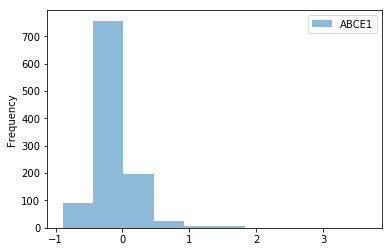

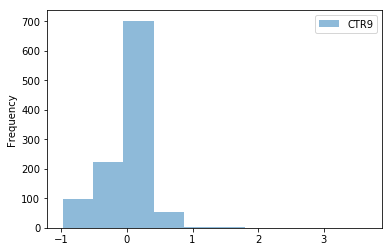

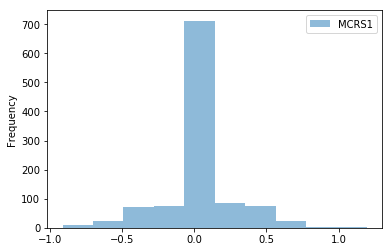

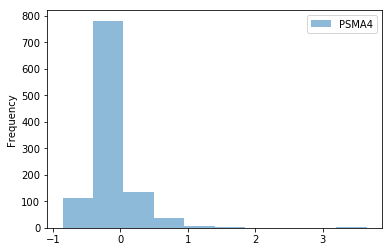

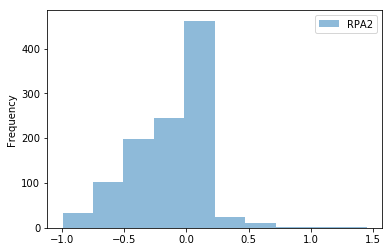

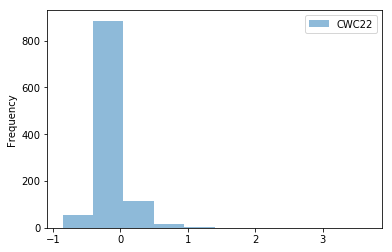

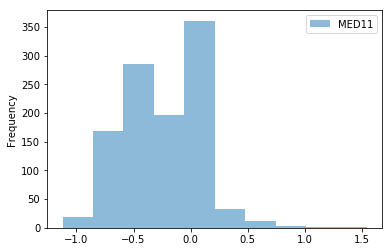

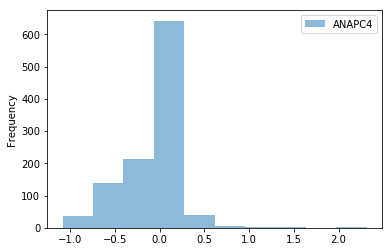

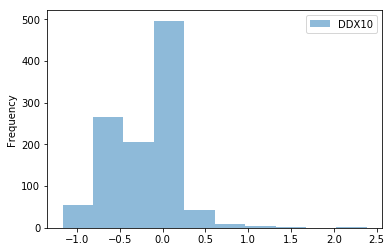

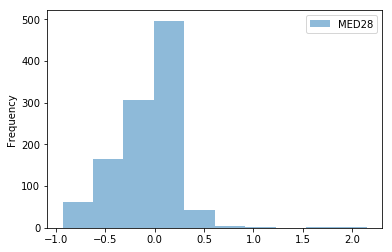

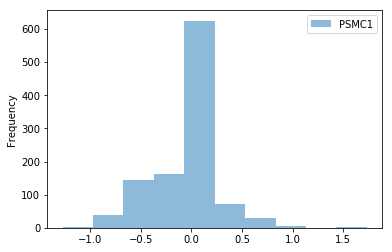

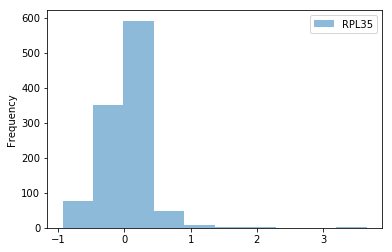

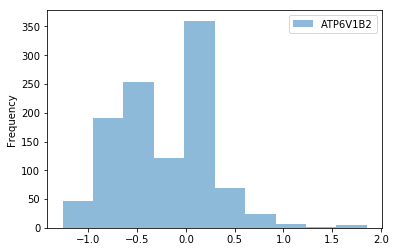

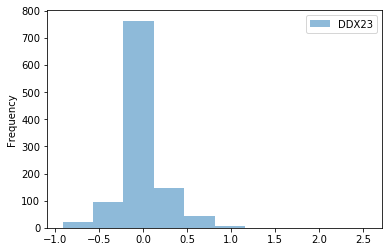

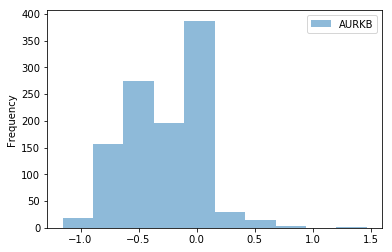

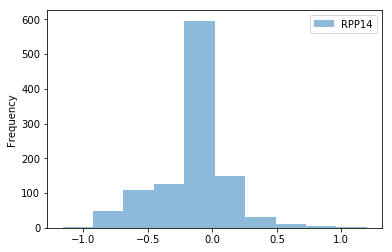

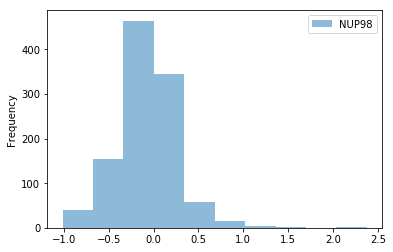

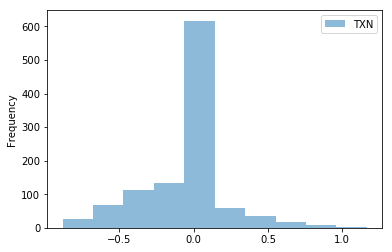

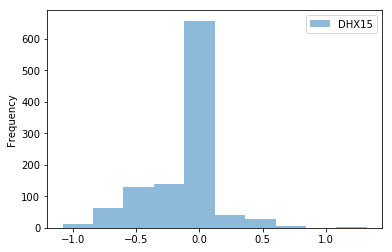

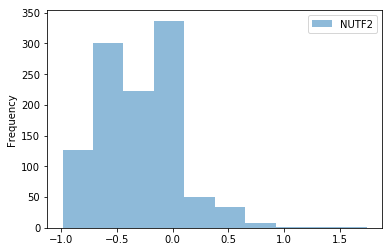

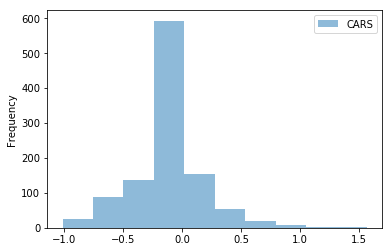

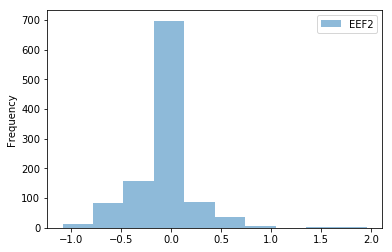

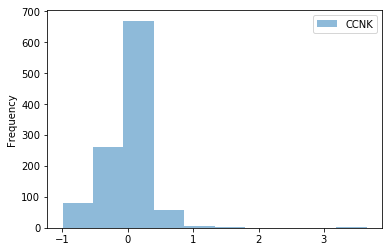

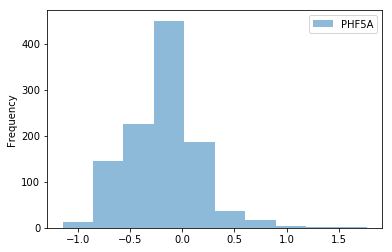

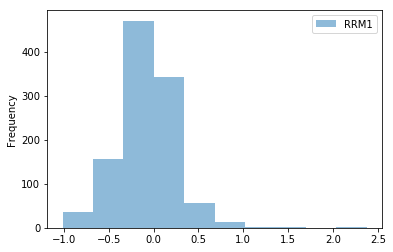

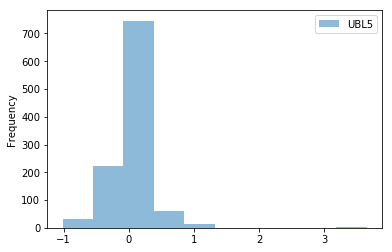

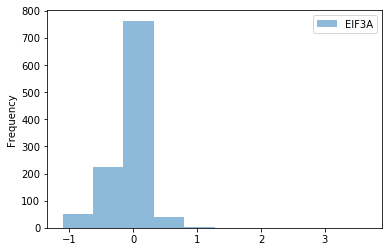

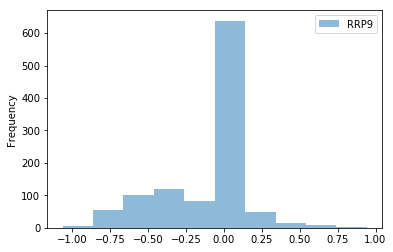

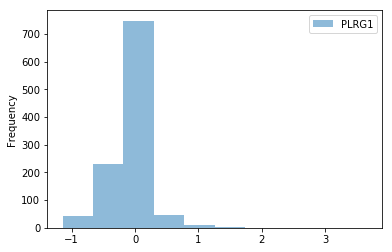

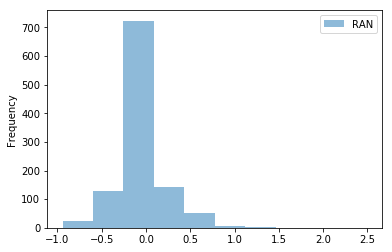

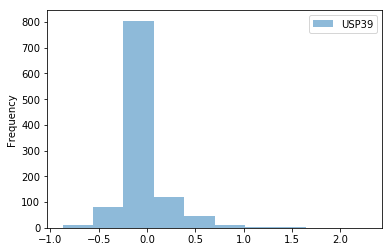

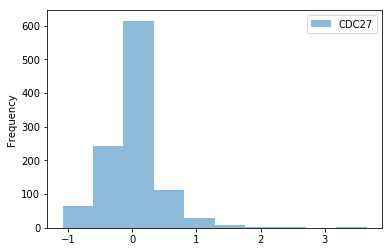

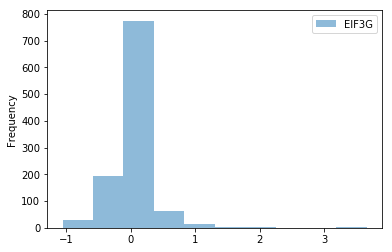

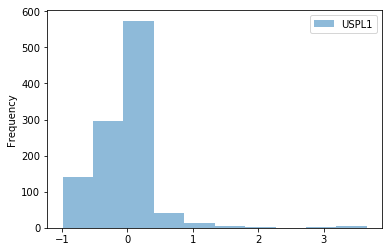

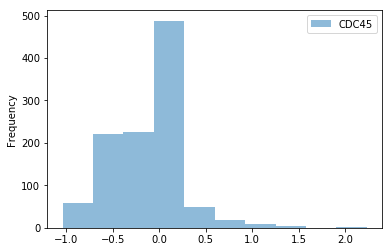

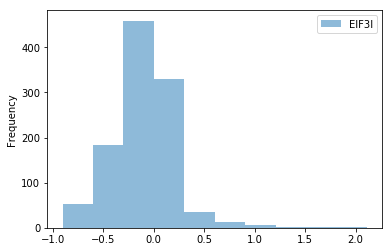

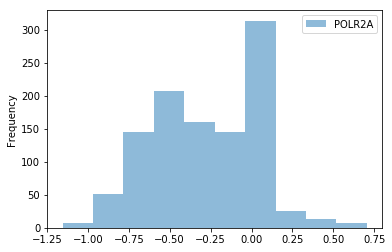

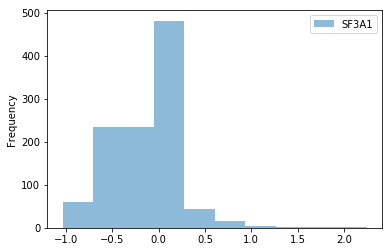

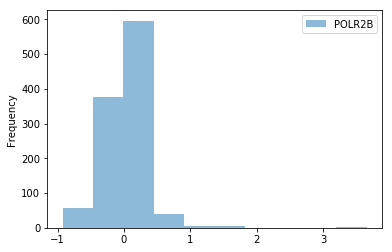

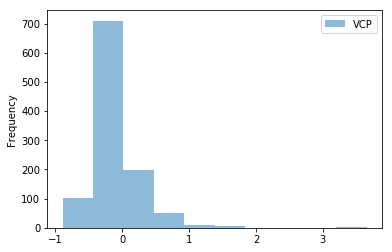

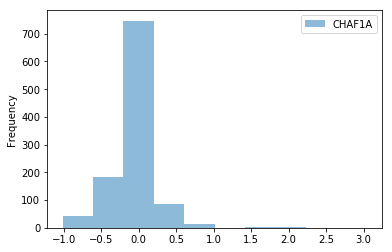

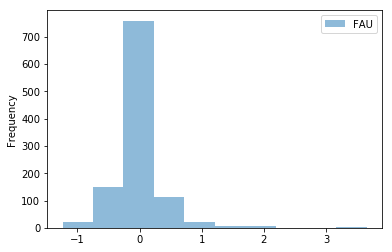

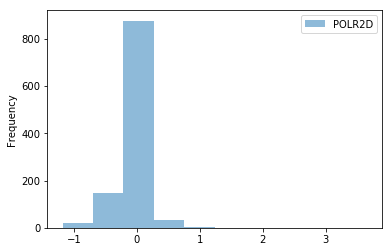

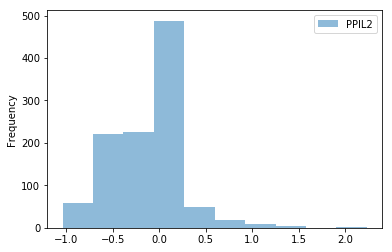

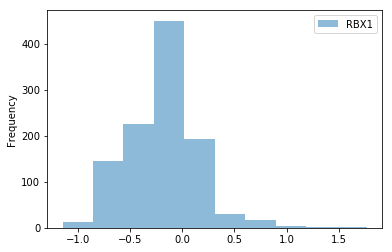

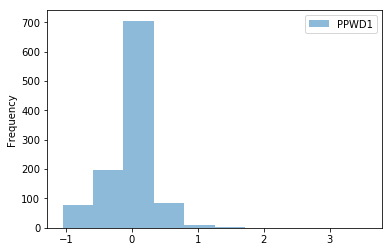

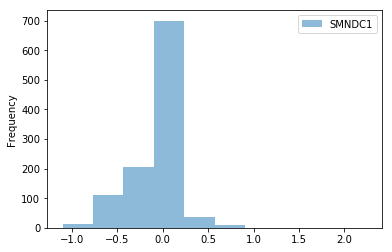

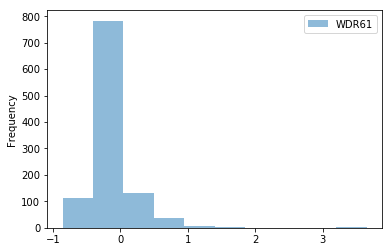

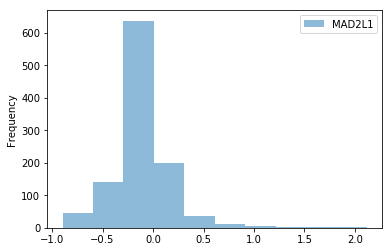

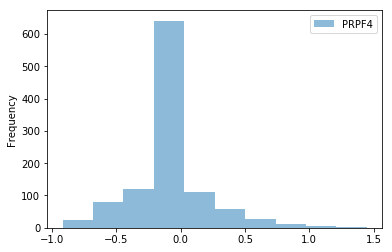

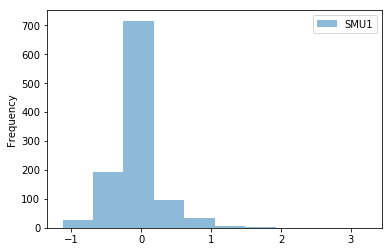

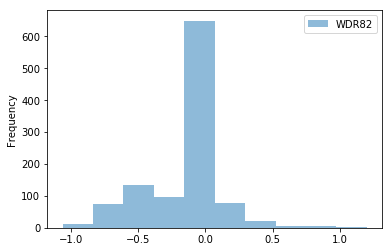

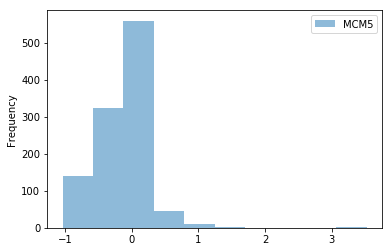

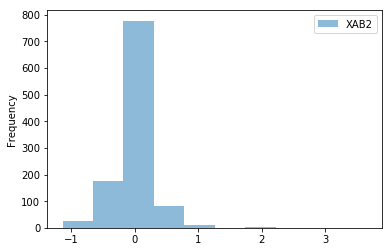

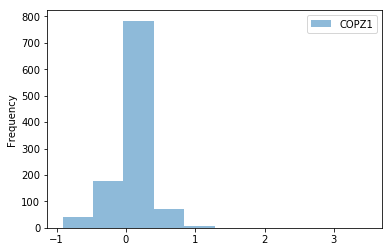

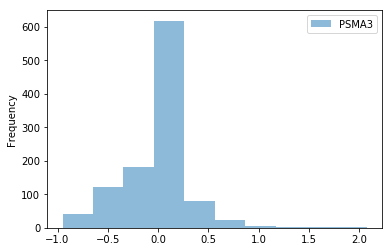

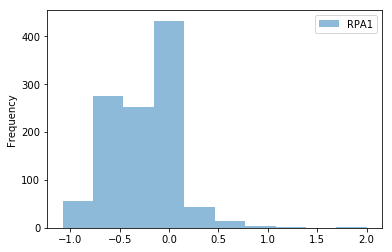

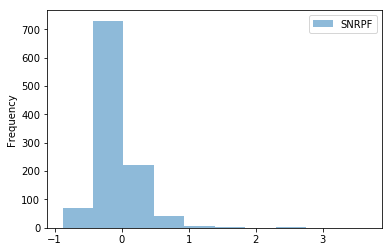

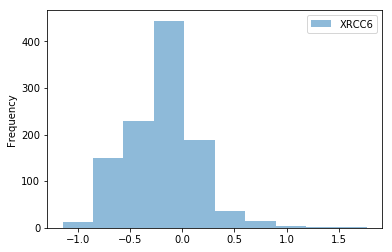

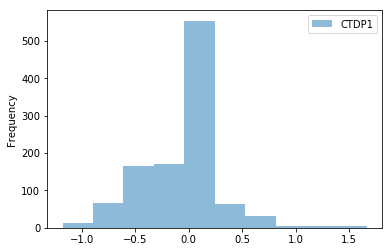

In [13]:
cyclops_all = cnv_val_df.loc[list(cyclops), :].transpose()
ls = []
for i in cyclops_all.columns:
    #flag = 1.5 * cyclops_all[i][cyclops_all[i].values > 0].values.shape[0] < cyclops_all[i][cyclops_all[i].values < 0].values.shape[0]
    #flag = flag and (cyclops_all[i][cyclops_all[i].values < 0].values.shape[0] > cyclops_all[i][cyclops_all[i].values == 0].values.shape[0])
    flag = cyclops_all[i][cyclops_all[i].values < 0].values.shape[0] > cyclops_all[i][cyclops_all[i].values > 0].values.shape[0]
    if flag:
        plt.figure()
        cyclops_all[i].plot.hist(legend=True, alpha=0.5)
        plt.show()
        ls.append(i)

In [14]:
for i in ls:
    print i

ABCE1
CTR9
MCRS1
PSMA4
RPA2
CWC22
MED11
ANAPC4
DDX10
MED28
PSMC1
RPL35
ATP6V1B2
DDX23
AURKB
RPP14
NUP98
TXN
DHX15
NUTF2
CARS
EEF2
CCNK
PHF5A
RRM1
UBL5
EIF3A
RRP9
PLRG1
RAN
USP39
CDC27
EIF3G
USPL1
CDC45
EIF3I
POLR2A
SF3A1
POLR2B
VCP
CHAF1A
FAU
POLR2D
PPIL2
RBX1
PPWD1
SMNDC1
WDR61
MAD2L1
PRPF4
SMU1
WDR82
MCM5
XAB2
COPZ1
PSMA3
RPA1
SNRPF
XRCC6
CTDP1


In [15]:
len(ls)

60